In [44]:
import pandas as pd
from rdkit.Chem import PandasTools, Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import DataStructs
import numpy as np
import pandas as pd
from rdkit import Chem
from curate.chem import structure_curation as cur
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score,matthews_corrcoef,f1_score,recall_score, roc_auc_score, balanced_accuracy_score, make_scorer
import random
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_validate, KFold
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestRegressor
from nonconformist.base import ClassifierAdapter
from nonconformist.nc import  ClassifierNc
from nonconformist.icp import IcpClassifier
from nonconformist.acp import AggregatedCp
from nonconformist.acp import BootstrapSampler, CrossSampler, RandomSubSampler
from nonconformist.acp import BootstrapConformalClassifier
from nonconformist.acp import CrossConformalClassifier
from nonconformist.evaluation import class_mean_errors, class_n_correct
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import warnings
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from rdkit.Chem import PandasTools
from sklearn.neighbors import KNeighborsRegressor
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

warnings.filterwarnings("ignore")

def fingerprints_inputs(dataframe,part=None):

    if part=='Train':
        X=np.array([AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=2048,useFeatures=True) for mol in [Chem.MolFromSmiles(m) for m in list(dataframe.canonical_smiles)]])
        y=dataframe.pchembl_value.astype('float')
    elif part=='Test':
        X=np.array([AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=2048,useFeatures=True) for mol in [Chem.MolFromSmiles(m) for m in list(dataframe.Smiles)]])
        y=dataframe.Activity.astype('int')
    return X,y

df_work=pd.read_excel("dat_def.xlsx",index_col=0,engine='openpyxl')

#### For building LLM first we load each transporter dataset and filter by IC50 and convert to float astype

In [4]:
df_bcrp=PandasTools.LoadSDF(r"C:\Users\parod\OneDrive\Escritorio\Doctorado\etransafe_aop\Datasets\chembl_data_bcrp.sdf")
df_bcrp['inchi']=[Chem.MolToInchi(m) for m in df_bcrp.ROMol]
df_bcrp=df_bcrp[df_bcrp.standard_type=='IC50']
df_bcrp['pchembl_value']=df_bcrp['pchembl_value'].astype('float')
df_mrp2=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_mrp2.sdf")
df_mrp2['inchi']=[Chem.MolToInchi(m) for m in df_mrp2.ROMol]
df_mrp2=df_mrp2[df_mrp2.standard_type=='IC50']
df_mrp2['pchembl_value']=df_mrp2['pchembl_value'].astype('float')
df_mrp3=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_mrp3.sdf")
df_mrp3['inchi']=[Chem.MolToInchi(m) for m in df_mrp3.ROMol]
df_mrp3=df_mrp3[df_mrp3.standard_type=='IC50']
df_mrp3['pchembl_value']=df_mrp3['pchembl_value'].astype('float')
df_mrp4=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_mrp4.sdf")
df_mrp4['inchi']=[Chem.MolToInchi(m) for m in df_mrp4.ROMol]
df_mrp4=df_mrp4[df_mrp4.standard_type=='IC50']
df_mrp4['pchembl_value']=df_mrp4['pchembl_value'].astype('float')
df_oat1=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_OATP1b1.sdf")
df_oat1['inchi']=[Chem.MolToInchi(m) for m in df_oat1.ROMol]
df_oat1=df_oat1[df_oat1.standard_type=='IC50']
df_oat1['pchembl_value']=df_oat1['pchembl_value'].astype('float')
df_oat2=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_OATP1b3.sdf")
df_oat2['inchi']=[Chem.MolToInchi(m) for m in df_oat2.ROMol]
df_oat2=df_oat2[df_oat2.standard_type=='IC50']
df_oat2['pchembl_value']=df_oat2['pchembl_value'].astype('float')
df_bsep=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_bsep.sdf")
df_bsep['inchi']=[Chem.MolToInchi(m) for m in df_bsep.ROMol]
df_bsep=df_bsep[df_bsep.standard_type=='IC50']
df_bsep['pchembl_value']=df_bsep['pchembl_value'].astype('float')
df_pgp=PandasTools.LoadSDF(r"C:/Users/parod/OneDrive/Escritorio/Doctorado/etransafe_aop/Datasets/chembl_data_pgp.sdf")
df_pgp['inchi']=[Chem.MolToInchi(m) for m in df_pgp.ROMol]
df_pgp=df_pgp[df_pgp.standard_type=='IC50']
df_pgp['pchembl_value']=df_pgp['pchembl_value'].astype('float')

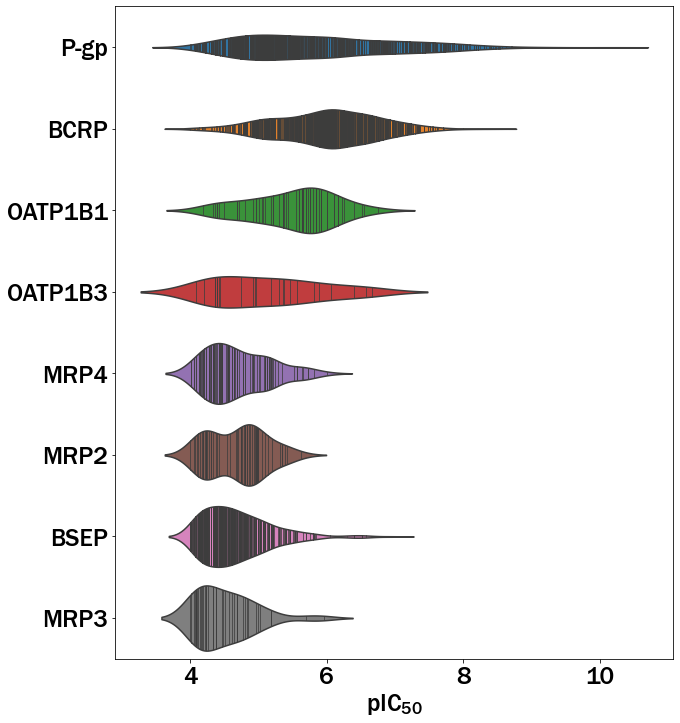

In [6]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.rcParams["font.family"] = 'Franklin Gothic Medium'
plt.rcParams.update({'font.size': 25})

# Set custom x-axis tick labels
x_labels = ['P-gp','BCRP', 'OATP1B1', 'OATP1B3','MRP4','MRP2', 'BSEP','MRP3']

arrays2=[df_pgp.pchembl_value.values,df_bcrp.pchembl_value.values,df_oat1.pchembl_value.values,df_oat2.pchembl_value.values,df_mrp4.pchembl_value.values,df_mrp2.pchembl_value.values,df_bsep.pchembl_value.values,df_mrp3.pchembl_value.values]
# Create a dataframe for plotting
data = []
for i, array in enumerate(arrays2):
    data.extend([(x_labels[i], value) for value in array])

df_ = pd.DataFrame(data, columns=['Transporter', 'pIC50'])

# Plot the violinplot with Seaborn
fig=plt.figure(figsize=(10, 12))
sns.violinplot(x='pIC50', y='Transporter', data=df_, inner='stick')

# Set x-axis tick labels
plt.yticks(range(len(x_labels)), x_labels)

plt.xlabel('$pIC_{50}$')
plt.ylabel('')
# Show the plot
plt.show()

#### We compute fingerprints for each set of transporters

In [12]:
X_bcrp,y_bcrp=fingerprints_inputs(df_bcrp,part='Train')
X_mrp2,y_mrp2=fingerprints_inputs(df_mrp2,part='Train')
X_mrp3,y_mrp3=fingerprints_inputs(df_mrp3,part='Train')
X_mrp4,y_mrp4=fingerprints_inputs(df_mrp4,part='Train')
X_oat1,y_oat1=fingerprints_inputs(df_oat1,part='Train')
X_oat2,y_oat2=fingerprints_inputs(df_oat2,part='Train')
X_bsep,y_bsep=fingerprints_inputs(df_bsep,part='Train')
X_pgp,y_pgp=fingerprints_inputs(df_pgp,part='Train')

#### In the next cell we extract drugs which are in the cholestasis dataset and each test would correspond to the set of drugs of the cholestasis dataset without activity

In [16]:
bcrp_coincidencias=pd.merge(df_work,df_bcrp,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_bcp=df_work.loc[~df_work.index.isin(bcrp_coincidencias.index)]
mrp2_coincidencias=pd.merge(df_work,df_mrp2,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_mrp2=df_work.loc[~df_work.index.isin(mrp2_coincidencias.index)]
mrp3_coincidencias=pd.merge(df_work,df_mrp3,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_mrp3=df_work.loc[~df_work.index.isin(mrp3_coincidencias.index)]
mrp4_coincidencias=pd.merge(df_work,df_mrp4,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_mrp4=df_work.loc[~df_work.index.isin(mrp4_coincidencias.index)]
oat1_coincidencias=pd.merge(df_work,df_oat1,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_oat1=df_work.loc[~df_work.index.isin(oat1_coincidencias.index)]
oat2_coincidencias=pd.merge(df_work,df_oat2,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_oat2=df_work.loc[~df_work.index.isin(oat2_coincidencias.index)]
bsep_coincidencias=pd.merge(df_work,df_bsep,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_bsep=df_work.loc[~df_work.index.isin(bsep_coincidencias.index)]
pgp_coincidencias=pd.merge(df_work,df_pgp,on='ID',right_index=True)[['name','ID','Smiles','Activity','ROMol','pchembl_value']]
test_pgp=df_work.loc[~df_work.index.isin(pgp_coincidencias.index)]

In [19]:
X_test_bcrp,y_test=fingerprints_inputs(test_bcp,part='Test')
X_test_mrp2,_=fingerprints_inputs(test_mrp2,part='Test')
X_test_mrp3,_=fingerprints_inputs(test_mrp3,part='Test')
X_test_mrp4,_=fingerprints_inputs(test_mrp4,part='Test')
X_test_oat1,_=fingerprints_inputs(test_oat1,part='Test')
X_test_oat2,_=fingerprints_inputs(test_oat2,part='Test')
X_test_bsep,_=fingerprints_inputs(test_bsep,part='Test')
X_test_pgp,_=fingerprints_inputs(test_pgp,part='Test')

In [20]:
def gridsearch_manual(X,y):
    from sklearn.model_selection import GridSearchCV,KFold
    from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error
    from xgboost import XGBRegressor
    import random
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    from sklearn.neighbors import KNeighborsRegressor
    
    random.seed(46)
    models1 = {
        'xgboost': XGBRegressor(random_state=46),
        'RandomForest': RandomForestRegressor(random_state=46),
        'KNN':KNeighborsRegressor(),
        'SVC': SVR()
    }

    params1 = {'xgboost': {'n_estimators': [16, 32,80, 100],'max_depth':[None,2,4,8],'min_child_weight': [1,2,4,6],'colsample_bytree': [0.5,1]},
        'RandomForest': { 'n_estimators': [16, 32,80, 100],'criterion':['mse'],'min_samples_split': [2, 3, 4,5],'max_depth':[None,2,4,8] },
        'KNN': { 'n_neighbors': list(range(1, 31)) },
        'SVC': {'kernel': ['linear','rbf'], 'C': [1, 10],'gamma': [0.001, 0.0001]}

    }

    # X=df_nuevo_def.iloc[:,2:-1]
    # y=df_nuevo_def.iloc[:,-1]
    # X_tr,X_te,y_tr,y_te=train_test_split(X,y,random_state=666,shuffle=True,train_size=0.65)
    grid_searches_metamodel = {'Classifier':[],'best_params':[],'best_score':[]}

    for key in models1.keys():
        print("Running GridSearchCV for %s." % key)
        model = models1[key]
        params = params1[key]
        gs = GridSearchCV(model, params, cv=KFold(5),
                          verbose=1, scoring=make_scorer(mean_absolute_error), refit=False,
                          return_train_score=True)
        gs.fit(X,y)
        grid_searches_metamodel['Classifier'].append(key)
        grid_searches_metamodel['best_params'].append(gs.best_params_)
        grid_searches_metamodel['best_score'].append(gs.best_score_)

    return pd.DataFrame(grid_searches_metamodel)

In [ ]:
tots_grids_bcrp=gridsearch_manual(X_bcrp,y_bcrp)
tots_grids_mrp2=gridsearch_manual(X_mrp2,y_mrp2)
tots_grids_mrp3=gridsearch_manual(X_mrp3,y_mrp3)
tots_grids_mrp4=gridsearch_manual(X_mrp4,y_mrp4)
tots_grids_bsep=gridsearch_manual(X_bsep,y_bsep)
tots_grids_oat1=gridsearch_manual(X_oat1,y_oat1)
tots_grids_oat2=gridsearch_manual(X_oat2,y_oat2)
tots_grids_pgp=gridsearch_manual(X_pgp,y_pgp)

#### After of running the previous cell we obtain the best model and set of hyperparameters for each LLM. So we build each model.

In [21]:
from sklearn.neighbors import KNeighborsRegressor
import random
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

random.seed(46)

model_bcrp=RandomForestRegressor(**{'criterion': 'mse', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 16},random_state=46).fit(X_bcrp,y_bcrp)

model_mrp2=RandomForestRegressor(**{'criterion': 'mse', 'max_depth': None, 'min_samples_split': 3, 'n_estimators': 16},random_state=46).fit(X_mrp2,y_mrp2)

model_mrp3=SVR(**{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}).fit(X_mrp3,y_mrp3)

model_mrp4=RandomForestRegressor(**{'criterion': 'mse', 'max_depth': None, 'min_samples_split': 3, 'n_estimators': 80},random_state=46).fit(X_mrp4,y_mrp4)

model_oat1=RandomForestRegressor(**{'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 5, 'n_estimators': 16},random_state=46).fit(X_oat1,y_oat1)

model_oat2=SVR(**{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}).fit(X_oat2,y_oat2)

model_bsep=XGBRegressor(**{'colsample_bytree': 1, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 16}).fit(X_bsep,y_bsep)

model_pgp=RandomForestRegressor(**{'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 16},random_state=46).fit(X_pgp,y_pgp)

#### After you run cross-validations with a Repeated k-fold

In [22]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

cv_bcrp=cross_val_score(model_bcrp,X_bcrp,y_bcrp,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_mrp2=cross_val_score(model_mrp2,X_mrp2,y_mrp2,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_mrp3=cross_val_score(model_mrp3,X_mrp3,y_mrp3,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_mrp4=cross_val_score(model_mrp4,X_mrp4,y_mrp4,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_oat1=cross_val_score(model_oat1,X_oat1,y_oat1,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_oat2=cross_val_score(model_oat2,X_oat2,y_oat2,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_bsep=cross_val_score(model_bsep,X_bsep,y_bsep,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))
cv_pgp=cross_val_score(model_pgp,X_pgp,y_pgp,cv=RepeatedKFold(20,5),scoring=make_scorer(mean_absolute_error))

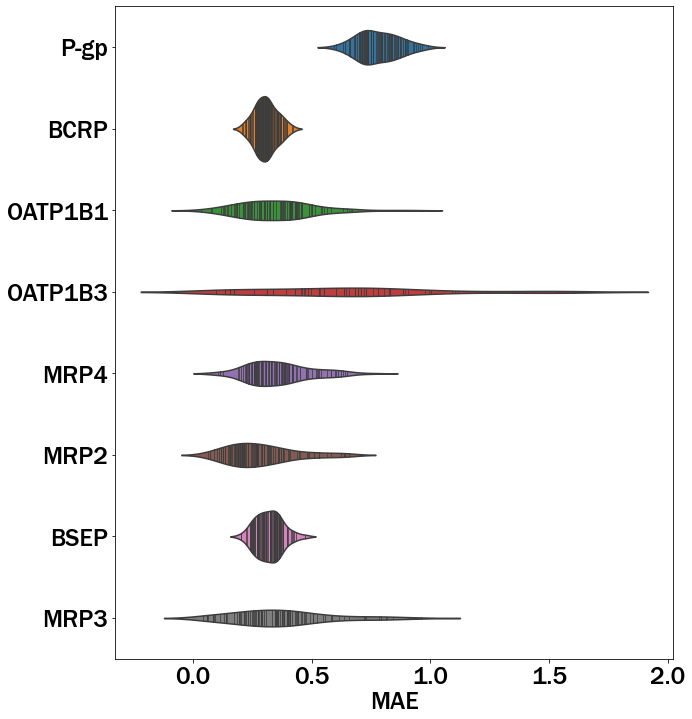

In [23]:
arrays2=[cv_pgp, cv_bcrp,cv_oat1,cv_oat2, cv_mrp4, cv_mrp2,cv_bsep, cv_mrp3]

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.rcParams["font.family"] = 'Franklin Gothic Medium'
plt.rcParams.update({'font.size': 25})

# Set custom x-axis tick labels
x_labels = ['P-gp','BCRP', 'OATP1B1', 'OATP1B3','MRP4','MRP2', 'BSEP','MRP3']

# Create a dataframe for plotting
data = []
for i, array in enumerate(arrays2):
    data.extend([(x_labels[i], value) for value in array])

df_ = pd.DataFrame(data, columns=['Transporter', 'MAE'])

# Plot the violinplot with Seaborn
fig=plt.figure(figsize=(10, 12))
sns.violinplot(x='MAE', y='Transporter', data=df_, inner='stick')

# Set x-axis tick labels
plt.yticks(range(len(x_labels)), x_labels)

plt.ylabel('')
# Show the plot
plt.show()

#### Once you have built each LLM you can predict unknown values for each transporter of the cholestasis dataset. And the next step consist of computing fub and clint with opera and MWeight and LogP with Rdkit for after using httk for obtaining in vivo doses.

In [29]:
definitive=pd.read_excel('definitive_dataset_with_all.xlsx',engine='openpyxl',index_col=0)

#### Visualizing distributions of pIC50

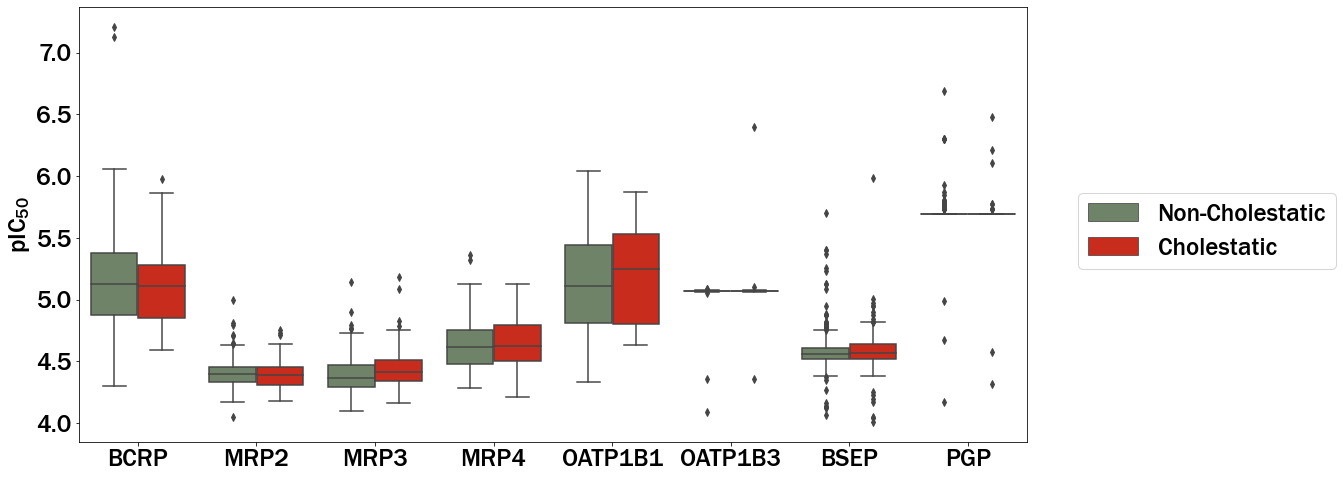

In [30]:
ic=definitive[['BCRP','MRP2','MRP3','MRP4','OATP1B1','OATP1B3','BSEP','PGP','Activity']]
fig=plt.figure(figsize=(17,8))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.rcParams["font.family"] = 'Franklin Gothic Medium'
plt.rcParams.update({'font.size': 25})
b=ic.melt( value_vars=ic.iloc[:,:-1].columns.tolist(),id_vars=['Activity'])
b['Activity']=b['Activity'].replace(1,'Cholestatic')
b['Activity']=b['Activity'].replace(0,'Non-Cholestatic')
b.loc[b['Activity']=='Cholestatic','Color']='#e51400'
b.loc[b['Activity']=='Non-Cholestatic','Color']='#6d8764'
my_pal = {"Cholestatic": "#e51400", "Non-Cholestatic": "#6d8764"}
box_plot=sns.boxplot(x="variable",y="value",data=b,hue='Activity',palette=my_pal)
plt.xticks(np.arange(0,8),['BCRP', 'MRP2', 'MRP3', 'MRP4', 'OATP1B1', 'OATP1B3', 'BSEP','PGP'])
# sta(-0.3,0.3,s='ns')
# sta(0.7,1.3,s='ns')
# sta(1.7,2.3,s='*')
# sta(2.7,3.3,s='*')
# sta(3.7,4.3,s='*')
# sta(4.7,5.3,s='ns')
# sta(5.7,6.3,s='*')
# sta(6.7,7.3,s='*')
plt.ylabel('p$IC_{50}$')
# plt.ylim(-4,12)
plt.xlabel('')

plt.legend(bbox_to_anchor=(1.04, 0.6));

In [35]:
model = ols('value ~ Activity * variable', b).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq      df            F    PR(>F)
Activity             0.043778     1.0     0.865223  0.352348
variable           609.476332     7.0  1720.792462  0.000000
Activity:variable    1.017816     7.0     2.873697  0.005419
Residual           168.793746  3336.0          NaN       NaN


#### Visualizing distributions of in vivo doses

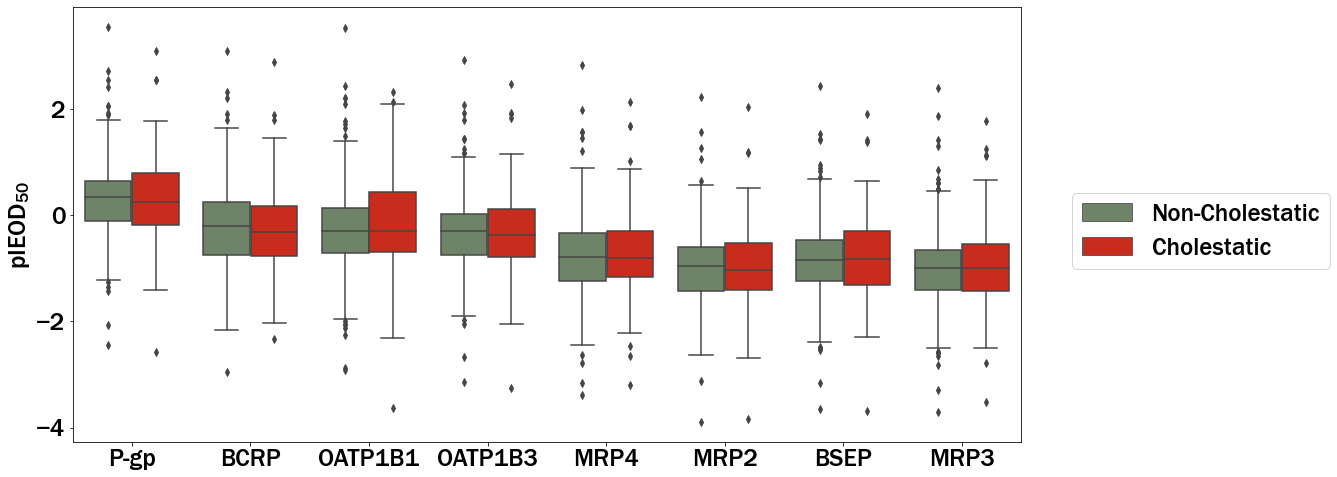

In [40]:
df_routes2_convert=-np.log10(definitive.iloc[:,22:-1])
df_routes2_convert_total=pd.concat([definitive[['name','Smiles']],df_routes2_convert,definitive[['Activity']]],axis=1)
df_routes2_convert_total2=df_routes2_convert_total[['0.9_oral_dose_pgp','0.9_oral_dose_bcrp','0.9_oral_dose_oat1', '0.9_oral_dose_oat2','0.9_oral_dose_mrp4',
                         '0.9_oral_dose_mrp2','0.9_oral_dose_bsep','0.9_oral_dose_mrp3','Activity']]
a=df_routes2_convert_total2.melt( value_vars=df_routes2_convert_total2.iloc[:,:-1].columns.tolist(),id_vars=['Activity'])

fig=plt.figure(figsize=(17,8))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.rcParams["font.family"] = 'Franklin Gothic Medium'
plt.rcParams.update({'font.size': 25})
a=df_routes2_convert_total2.melt( value_vars=df_routes2_convert_total2.iloc[:,:-1].columns.tolist(),id_vars=['Activity'])
a['Activity']=a['Activity'].replace(1,'Cholestatic')
a['Activity']=a['Activity'].replace(0,'Non-Cholestatic')
a.loc[a['Activity']=='Cholestatic','Color']='#e51400'
a.loc[a['Activity']=='Non-Cholestatic','Color']='#6d8764'
my_pal = {"Cholestatic": "#e51400", "Non-Cholestatic": "#6d8764"}
box_plot=sns.boxplot(x="variable",y="value",data=a,hue='Activity',palette=my_pal)
plt.xticks(np.arange(0,8),['P-gp','BCRP','OATP1B1','OATP1B3','MRP4','MRP2','BSEP','MRP3'])
# sta(-0.3,0.3,s='ns')
# sta(0.7,1.3,s='ns')
# sta(1.7,2.3,s='*')
# sta(2.7,3.3,s='*')
# sta(3.7,4.3,s='*')
# sta(4.7,5.3,s='ns')
# sta(5.7,6.3,s='*')
# sta(6.7,7.3,s='*')
plt.ylabel('p$IEOD_{50}$')
# plt.ylim(-4,12)
plt.xlabel('')

plt.legend(bbox_to_anchor=(1.04, 0.6));

In [41]:
model = ols('value ~ Activity * variable', a).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                        sum_sq      df           F         PR(>F)
Activity              1.182033     1.0    1.986346   1.588167e-01
variable            609.479905     7.0  146.314204  1.020489e-188
Activity:variable     1.017651     7.0    0.244301   9.740965e-01
Residual           1985.184637  3336.0         NaN            NaN


#### We build Scikit-Learn estimator types for pk and not_pk modelling for using all the utilities of Scikit-Learn

In [37]:
class LogicalOrEstimatorpk(BaseEstimator, TransformerMixin):
    def __init__(self, k=1):
        self.k = k
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        # Apply the logical OR rule to the test data
        pred = np.where(X['Doses max'].values>self.k*X.iloc[:,22:-1].max(1).values,1,0)
        return pred
    def get_params(self, deep=True):
        return {"k": self.k}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [38]:
class LogicalOrEstimatornotPK(BaseEstimator, TransformerMixin):
    def __init__(self,threshold=1):
        
        self.threshold=threshold

    def fit(self, X, y):
        return self
    
    def predict(self, X):
        # Apply the logical OR rule to the test data
        IC50=10**(-X[['BCRP','MRP2','MRP3','MRP4','OATP1B1','OATP1B3','BSEP','PGP']])*1e6
        idg=pd.DataFrame(np.where(IC50<=self.threshold,1,0))
        pred=np.where(idg.any(1)==True,1,0)
        return pred
    
    def get_params(self, deep=True):
        return {"threshold": self.threshold}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### As an example in the next cell we build our pk model and make a gridsearch using roc_auc as score metric

In [45]:
### Example

ensembl_modelpk=LogicalOrEstimatorpk(k=None).fit(definitive,definitive.Activity)

random.seed(46)

gs=GridSearchCV(ensembl_modelpk, param_grid={'k':np.linspace(0,15,100)},
                          verbose=1, scoring=make_scorer(roc_auc_score), refit=False,
                          return_train_score=True)
gs.fit(definitive,definitive.Activity)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=LogicalOrEstimatorpk(k=None),
             param_grid={'k': array([ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061,
        0.75757576,  0.90909091,  1.06060606,  1.21212121,  1.36363636,
        1.51515152,  1.66666667,  1.81818182,  1.96969697,  2.12121212,
        2.27272727,  2.42424242,  2.57575758,  2.72727273,  2.87878788,
        3.03030303,  3.18181818,  3.33333333,  3.48484848,  3.63636364,
        3.7878787...
       11.36363636, 11.51515152, 11.66666667, 11.81818182, 11.96969697,
       12.12121212, 12.27272727, 12.42424242, 12.57575758, 12.72727273,
       12.87878788, 13.03030303, 13.18181818, 13.33333333, 13.48484848,
       13.63636364, 13.78787879, 13.93939394, 14.09090909, 14.24242424,
       14.39393939, 14.54545455, 14.6969697 , 14.84848485, 15.        ])},
             refit=False, return_train_score=True,
             scoring=make_scorer(roc_auc_score), verbose=1)

#### After of that you can compute cross_val_score for different metrics, for example for sensitivity

In [46]:
gs_ensembl_modelpk=LogicalOrEstimatorpk(**gs.best_params_).fit(definitive,definitive.Activity)

In [47]:
def calculate_sensitivity(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    sensitivity = true_positive / (true_positive + false_negative)
    return sensitivity

Sensitivity_metamodel_pk=cross_val_score(gs_ensembl_modelpk,df,df.Activity,scoring=make_scorer(calculate_sensitivity),cv=RepeatedKFold(20,5,random_state=46)).mean()

#### We have done the same for each proposed model and metric, this is only an example. After of that we built cross_validation using clustering and ATC codes, we are going to show the methodology for the ATC as an example since for the cluster it would be the same.

In [60]:
atc_dat_fold=definitive.copy()

In [61]:
### Here we built the indexes of ATC-based 5-fold CV

atc_dat_fold=atc_dat_fold[(atc_dat_fold.atc_desc2=='J01')|(atc_dat_fold.atc_desc2=='N05')|(atc_dat_fold.atc_desc2=='L01')|(atc_dat_fold.atc_desc2=='C01')|(atc_dat_fold.atc_desc2=='N02')]

atc_dat_fold=atc_dat_fold.reset_index(drop=True)

fold_atc=[(atc_dat_fold[atc_dat_fold.atc_desc2!='J01'].index.values,atc_dat_fold[atc_dat_fold.atc_desc2=='J01'].index.values),
(atc_dat_fold[atc_dat_fold.atc_desc2!='N05'].index.values,atc_dat_fold[atc_dat_fold.atc_desc2=='N05'].index.values),
(atc_dat_fold[atc_dat_fold.atc_desc2!='L01'].index.values,atc_dat_fold[atc_dat_fold.atc_desc2=='L01'].index.values),
(atc_dat_fold[atc_dat_fold.atc_desc2!='C01'].index.values,atc_dat_fold[atc_dat_fold.atc_desc2=='C01'].index.values),
(atc_dat_fold[atc_dat_fold.atc_desc2!='N02'].index.values,atc_dat_fold[atc_dat_fold.atc_desc2=='N02'].index.values)]

In [63]:
#### Now, for example you can build the previous model based on this CV.

ensembl_modelpk_atc=LogicalOrEstimatorpk(k=None).fit(atc_dat_fold,atc_dat_fold.Activity)

random.seed(46)

gs_atc=GridSearchCV(ensembl_modelpk_atc, param_grid={'k':np.linspace(0,15,100)},cv=fold_atc,
                          verbose=1, scoring=make_scorer(roc_auc_score), refit=False,
                          return_train_score=True)
gs_atc.fit(atc_dat_fold,atc_dat_fold.Activity)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  13,  14,
        15,  18,  19,  20,  21,  22,  24,  25,  28,  32,  33,  34,  35,
        36,  38,  39,  40,  41,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  60,  61,  62,  63,  64,  65,
        67,  69,  70,  72,  73,  74,  75,  78,  79,  80,  81,  84,  86,
        87,  89,  91,  92,  93,  94,  95,  98,  99, 100, 102, 103, 104,
       105, 106, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126,
       127, 129], dtype=int64),
                  array([  8,  12,  16,  17,  23,  2...
       11.36363636, 11.51515152, 11.66666667, 11.81818182, 11.96969697,
       12.12121212, 12.27272727, 12.42424242, 12.57575758, 12.72727273,
       12.87878788, 13.03030303, 13.18181818, 13.33333333, 13.48484848,
       13.63636364, 13.78787879, 13.93939394, 14.09090909, 14.24242424,
       14.39393939, 14.54545455, 14.6969697 , 14.84848485, 15.        ])},
             refit=False, r

#### Now you have the best set of hyperparameter for your metamodel_pk and you can make the ATC-based 5-fold CV

In [65]:
gs_ensembl_modelpk_atc=LogicalOrEstimatorpk(**gs_atc.best_params_).fit(atc_dat_fold,atc_dat_fold.Activity)
Sensitivity_metamodel_pk_atc_fold=cross_val_score(gs_ensembl_modelpk_atc,atc_dat_fold,atc_dat_fold.Activity,scoring=make_scorer(calculate_sensitivity),cv=fold_atc)